# Creates burndown chart for specified fixVersions

<div class="alert alert-block alert-success">
Specify the fixVersions that you'd like to estimate.
</div>

In [9]:
fixVersions = ['R1']

Loading data using JIRA API (https://jira.readthedocs.io/en/master/)

Password is provided using ~/.rcnet file

In [10]:
import pandas as pd
import numpy as np
from jira import JIRA


#store credentials in ~/.rcnet file
jira = JIRA('https://kainos-evolve.atlassian.net')
jql = 'project=ECL and fixversion in (' + ", ".join(fixVersions) + ') and (labels = Required_for_production_data and labels != sec_arch)'
jql

'project=ECL and fixversion in (R1) and (labels = Required_for_production_data and labels != sec_arch)'

Above JQL will be used to download the data from Jira

In [11]:
issuesInVersions = jira.search_issues(jql, maxResults = False)

issues = pd.DataFrame()
issues['version'] = ''
issues['key'] = ''
issues['type'] = ''
issues['status'] = ''
issues['SP'] = 0
issues['summary'] = ''

#add issues to dataframe
for issue in issuesInVersions:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in fixVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                 'remainingEffort': issue.fields.customfield_14500
                }, ignore_index=True)
            
issues.sort_values("version", inplace=True)
issues = issues.loc[~(issues['status'].isin(['Completed', 'Rejected', 'Done']))]

#only use remainingEffort if it's defined
def setRemainingSP(remainingEffort, SP):
    if(remainingEffort != None): return remainingEffort
    else: return SP

issues['RemainingSP'] = issues.apply(lambda x: setRemainingSP(x['remainingEffort'], x['SP']), axis=1)

#issues = issues.loc[(issues['team'].isin(['Gdansk Team 1']))]
issues

,version,key,type,status,SP,summary,remainingEffort,RemainingSP
0,R1,ECL-151,Story,Backlog,5.0,Overlay R1 changes to Brompton environments,None,5.0
23,R1,ECL-43,Story,Backlog,5.0,Define an operational responsibilities documen...,None,5.0
24,R1,ECL-42,Story,Backlog,5.0,Define a playbook of operational incidents - w...,1,1.0
25,R1,ECL-41,Story,Backlog,3.0,Define the DR approach for the solution,None,3.0
26,R1,ECL-33,Story,Backlog,5.0,Pull together all disparate log sources into a...,None,5.0
29,R1,ECL-27,Story,In Progress,5.0,Ensure that virus scanning is present,2,2.0
30,R1,ECL-26,Story,Backlog,5.0,Restrict internet access to specific data cent...,None,5.0
22,R1,ECL-50,Story,Backlog,3.0,Define a SysOps document for Kainos personnel....,1,1.0
31,R1,ECL-25,Story,Backlog,10.0,Apply NSGs between the various tiers in Evolve...,None,10.0
33,R1,ECL-23,Story,Backlog,5.0,Barracuda - configure for system integration e...,None,5.0


###### All stories should have SP value

<div class="alert alert-block alert-success">
Please review items below and add SP to issues where necessary. Missing estimations may skew the results later.
</div>

In [12]:
issues.loc[(issues['type'] == 'Story') & (issues['SP'].isnull())]


,version,key,type,status,SP,summary,remainingEffort,RemainingSP


In [13]:
#replace NaN values by 0 for grouping
issues = issues.fillna(0)
#issues = issues.groupby(['version'], as_index=False)['SP'].sum()
issues = issues.groupby(['version']).agg({'RemainingSP':'sum'})
issues

,RemainingSP
version,
R1,151.0


<div class="alert alert-block alert-success">
Manually calculate and set minimum, average and maximum velocity for the team 
</div>

In [14]:
minVelocity = 13
avgVelocity = 17
maxVelocity = 20

#sprint length in days
sprintLen = 5

Calculate days using velocity above

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
versions = pd.DataFrame()
#add some data to play with first
#versions['version'] = ['1.12', '1.13', '1.14']
#versions['SP'] = [33, 40, 38]

#or get data directly from Jira
versions = issues

import math
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay

#calculate days for each version using velocity and adjust with remaining time
#assuming that single person in the team is assigned to one task, first version will be finished 
#when the last person will finish her assignment. 
#From the other hand other members of the team may start working on next version in the same time.
#This is deliberate tradeof between accuracy of nearest version finish and last version delivery time.
#Another approach might be to measure remaining SP in started tasks - this should improve accuracy of latest version 
#delivery date at cost of losing some accuracy of nearest version.
versions['minVeloDays'] = np.ceil(versions.RemainingSP * sprintLen / minVelocity).astype(int)
versions['avgVeloDays'] = np.ceil(versions.RemainingSP * sprintLen / avgVelocity).astype(int)
versions['maxVeloDays'] = np.ceil(versions.RemainingSP * sprintLen / maxVelocity).astype(int)

#round up days
minVeloDays = math.ceil(sum(versions.minVeloDays))
avgVeloDays = math.ceil(sum(versions.avgVeloDays))
maxVeloDays = math.ceil(sum(versions.maxVeloDays))


#calculate rolling sum of days up to the version
versions['minSum'] = versions.minVeloDays.expanding(1).sum().astype(int)
versions['avgSum'] = versions.avgVeloDays.expanding(1).sum().astype(int)
versions['maxSum'] = versions.maxVeloDays.expanding(1).sum().astype(int)

#replace NaN with 0
versions = versions.fillna(0)

#add business days to today to calculate finish date
versions['finishDateMinVelo'] = 0
versions['finishDateAvgVelo'] = 0
versions['finishDateMaxVelo'] = 0


versions.finishDateMinVelo = versions.minSum.apply(lambda x: pd.to_datetime('today') + BDay(x))
versions.finishDateAvgVelo = versions.avgSum.apply(lambda x: pd.to_datetime('today') + BDay(x))
versions.finishDateMaxVelo = versions.maxSum.apply(lambda x: pd.to_datetime('today') + BDay(x))

versions['minVeloDaysToFinish'] = 0
versions['avgVeloDaysToFinish'] = 0
versions['maxVeloDaysToFinish'] = 0
versions.minVeloDaysToFinish = minVeloDays - versions.minSum
versions.avgVeloDaysToFinish = avgVeloDays - versions.avgSum
versions.maxVeloDaysToFinish = maxVeloDays - versions.maxSum

versions = versions.reset_index()

#add first row with today to create burndown chart
versions = versions.append(
        {
          'version': 'today', 
         'finishDateMinVelo': pd.to_datetime('today'),
         'finishDateMaxVelo': pd.to_datetime('today'),
         'finishDateAvgVelo': pd.to_datetime('today'),
         'minVeloDaysToFinish': minVeloDays,
         'avgVeloDaysToFinish': avgVeloDays,
         'maxVeloDaysToFinish': maxVeloDays
        }, ignore_index=True)

versions.sort_values("finishDateMinVelo", inplace=True)

versions

,version,RemainingSP,minVeloDays,avgVeloDays,maxVeloDays,minSum,avgSum,maxSum,finishDateMinVelo,finishDateAvgVelo,finishDateMaxVelo,minVeloDaysToFinish,avgVeloDaysToFinish,maxVeloDaysToFinish
1,today,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-04-11,2018-04-11,2018-04-11,59,45,38
0,R1,151.0,59.0,45.0,38.0,59.0,45.0,38.0,2018-07-03,2018-06-13,2018-06-04,0,0,0


Plot data

Populating the interactive namespace from numpy and matplotlib


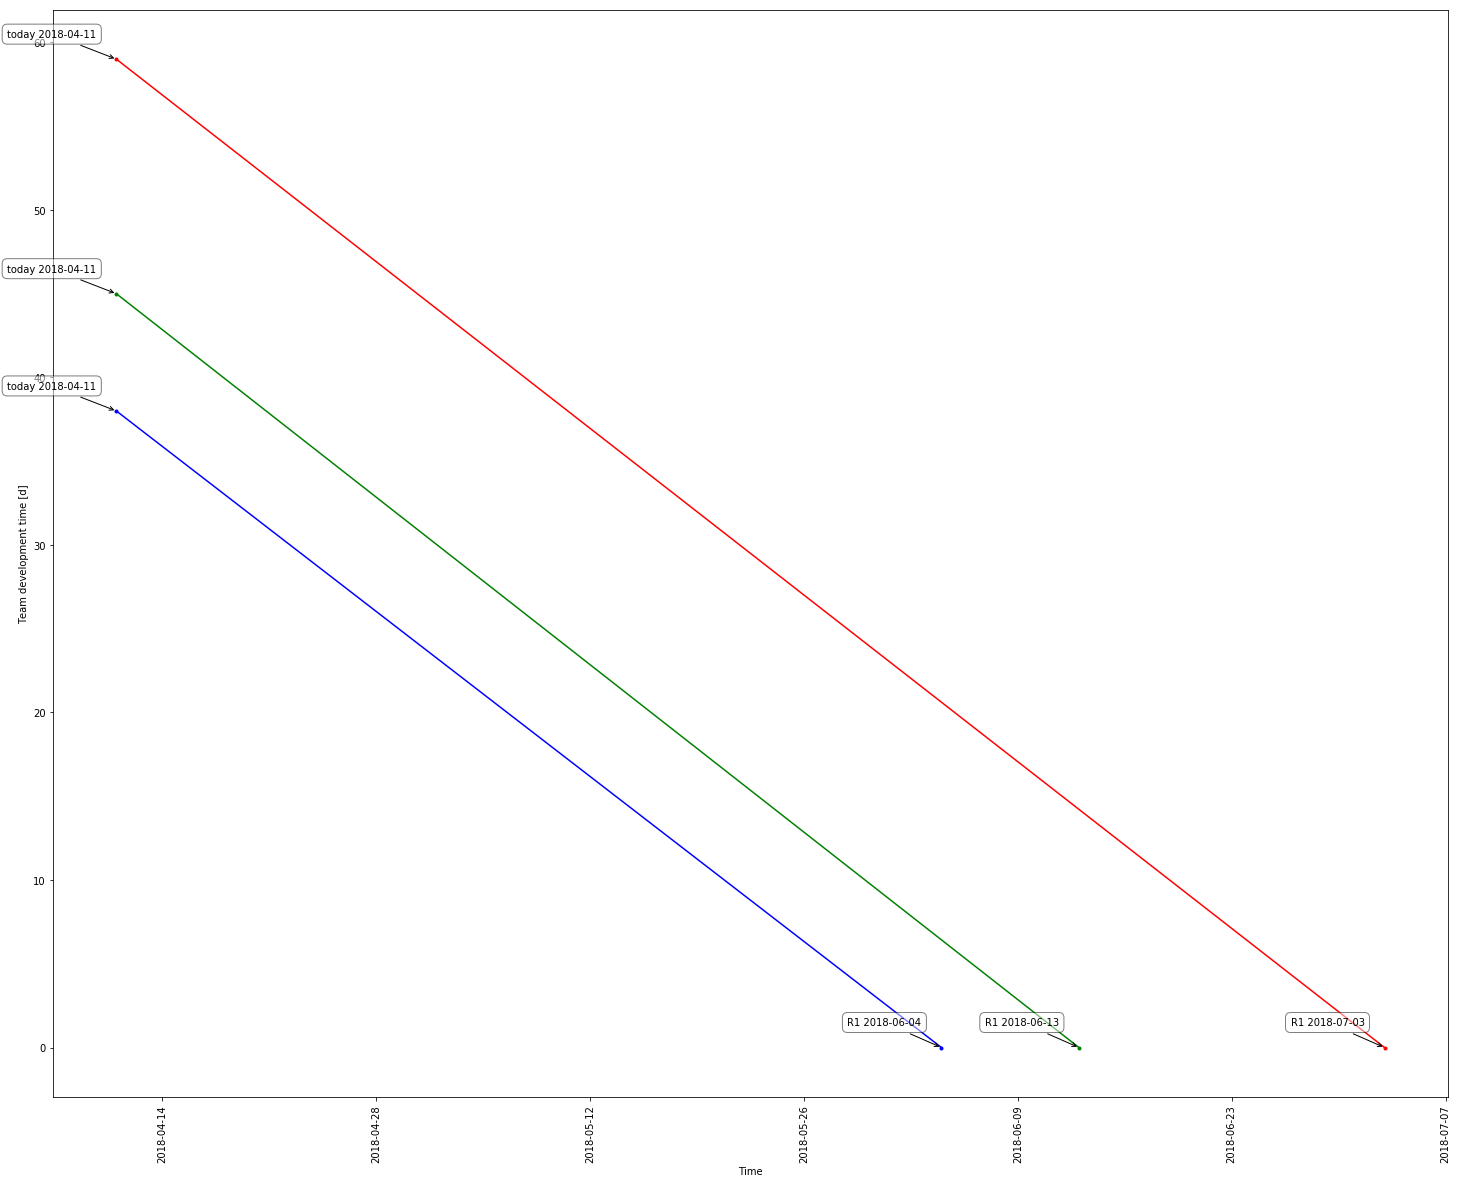

In [16]:




%pylab inline
pylab.rcParams['figure.figsize'] = (25, 20)

_ = plt.plot(versions['finishDateMinVelo'], versions['minVeloDaysToFinish'], "-r.")
_ = plt.plot(versions['finishDateAvgVelo'], versions['avgVeloDaysToFinish'], "-g.")
_ = plt.plot(versions['finishDateMaxVelo'], versions['maxVeloDaysToFinish'], "-b.")

_ = plt.xticks(rotation='vertical')
_ = plt.ylabel('Team development time [d]')
_ = plt.xlabel('Time')

for label, x, y in zip(versions['version'], versions['finishDateMinVelo'], versions['minVeloDaysToFinish']):
    _ = plt.annotate(
        label + " " + x.strftime('%Y-%m-%d'),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    
for label, x, y in zip(versions['version'], versions['finishDateAvgVelo'], versions['avgVeloDaysToFinish']):
    _ = plt.annotate(
        label + " " + x.strftime('%Y-%m-%d'),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


for label, x, y in zip(versions['version'], versions['finishDateMaxVelo'], versions['maxVeloDaysToFinish']):
    _ = plt.annotate(
        label + " " + x.strftime('%Y-%m-%d'),
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
